# Classify common european garden birds.
- using transfer learning with a pretrained [resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) model

In [ ]:
!pip install -U duckduckgo_search
!pip install fastcore
!pip install fastdownload
!pip install fastai

import torch 
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
# run on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Get urls for images from duckduckgo search.

In [4]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
# folder to store images
path = Path('gardenbirds')

Common british garden birds:

In [6]:
gardenbirds = {
'robin': 'Erithacus rubecula',
'collared dove': 'Streptopelia decaocto',
'great tit': 'Parus major',
'blue tit': 'Cyanistes caeruleus',
'coal tit': 'Periparus ater',
'goldfinch': 'Carduelis carduelis',
'chaffinch': 'Fringilla coelebs',
'wood pigeon': 'Columba palumbus',
'blackbird': 'Turdus merula',
'starling': 'Sturnus vulgaris',
'house sparrow': 'Passer domesticus',
'magpie': 'Pica pica',
'carrion crow': 'Corvus corone',
'european jay': 'Garrulus glandarius',
'wren': 'Troglodytes troglodytes',
'goldcrest': 'Regulus regulus',
'dunnock': 'Prunella modularis',
'long-tailed tit': 'Aegithalos caudatus',
'greenfinch': 'Carduelis chloris',
'green woodpecker': 'Picus viridis',
'bullfinch': 'Pyrrhula pyrrhula',
'common kingfisher': 'Alcedo atthis',
'great spotted woodpecker': 'Dendrocopos major',
'nuthatch': 'Sitta europaea',
'redwing': 'Turdus iliacus',
'blackcap': 'Sylvia atricapilla',
'song thrush': 'Turdus philomelos',
'treecreeper': 'Certhia familiaris',
'chiffchaff': 'Phylloscopus collybita',
'firecrest': 'Regulus ignicapilla',
'willow warbler': 'Phylloscopus trochilus',
'spotted flycatcher': 'Muscicapa striata'
}

Download images from DuckDuckGo for each species of kingfisher.

In [7]:
# # get 4 random species plus Alcedo atthis
# species = np.random.choice(kingfishers, 3, replace=False)
# species = np.append(species, 'Alcedo atthis')
# species

In [7]:
# clear folder
# !rm -rf gardenbirds

In [9]:
# get list of latin names for search
latin_names = list(gardenbirds.values())
#latin_names

In [ ]:
# download images
from time import sleep

for o in latin_names:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    results = search_images(o, max_images=50)
    download_images(dest, urls=search_images(f'{o}'), max_pics=50)
    sleep(2)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Find images that can't be opened and unlink them.

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

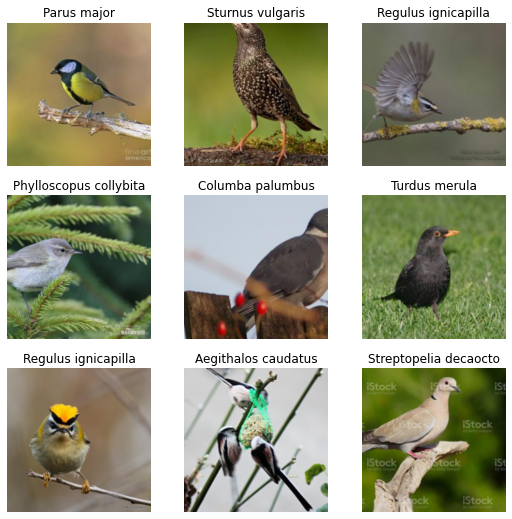

In [12]:
# show example images and labels
dls = ImageDataLoaders.from_folder(path, train='.', valid_pct=0.2, item_tfms=Resize(224), bs=32)
dls.show_batch()
    

Defining the image transformations.  
* For the training set, we'll use some random transformations to augment the data. 
* For the validation set, we'll just use the standard transformations.

In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Split dataset into training and validation sets.

In [23]:
# the folder structure is gardenbirds/species_name. Make a dataset
# with the species name as the label
dataset = ImageFolder(path)
dataset

# split into train and validation sets  
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# add transforms
train_dataset.dataset.transform = data_transforms['train']
test_dataset.dataset.transform = data_transforms['val']
len(train_dataset), len(test_dataset)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [24]:
# class names are sorted alphabetically
#class_names = dataset.classes
#class_names

In [25]:
len(latin_names)

32

Define model and hyperparameters.

In [26]:
# transfer learning: use resnet18 pretrained on imagenet and replace the last layer.
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(latin_names))
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer SGD with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
# train model function
def train_loop(model, criterion, optimizer, scheduler, num_epochs):
    train_losses, test_losses = [], []  # lists to store training and test losses
    for epoch in range(num_epochs):
        model.train()  # set the model to training mode
        size = len(train_loader.dataset)
        train_loss = 0.0  # initialize training loss for the epoch
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            
            # Compute prediction and loss
            pred = model(X)
            loss = criterion(pred, y)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()  # accumulate training loss
            
            if batch % 10 == 0:
                loss, current = loss.item(), batch * len(X)
                accuracy = (pred.argmax(1) == y).type(torch.float).mean().item()
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                print(f"Accuracy: {(100*accuracy):>0.1f}%")
                
        train_loss /= len(train_loader)  # compute average training loss for the epoch
        train_losses.append(train_loss)  # append training loss to the list
        
        model.eval()  # set the model to evaluation mode
        test_loss = 0.0  # initialize test loss for the epoch
        with torch.no_grad():  # deactivate gradient computation
            for batch, (X, y) in enumerate(test_loader):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = criterion(pred, y)
                test_loss += loss.item()  # accumulate test loss
                
        test_loss /= len(test_loader)  # compute average test loss for the epoch
        test_losses.append(test_loss)  # append test loss to the list
        
        # print training and test loss for the epoch
        print(f"epoch {epoch+1:>3d} | train_loss: {train_loss:.5f} | test_loss: {test_loss:.5f}")
        
    # plot training and test loss
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.legend()
    plt.show()

loss: 3.593802  [    0/  643]
Accuracy: 6.2%
loss: 3.539315  [  320/  643]
Accuracy: 6.2%
loss: 3.266570  [   60/  643]
Accuracy: 0.0%
epoch   1 | train_loss: 3.49115 | test_loss: 3.23270
loss: 2.845716  [    0/  643]
Accuracy: 34.4%
loss: 2.814723  [  320/  643]
Accuracy: 31.2%
loss: 3.007935  [   60/  643]
Accuracy: 33.3%
epoch   2 | train_loss: 2.75187 | test_loss: 2.59542
loss: 2.170314  [    0/  643]
Accuracy: 84.4%
loss: 1.904195  [  320/  643]
Accuracy: 68.8%
loss: 2.558231  [   60/  643]
Accuracy: 33.3%
epoch   3 | train_loss: 2.05390 | test_loss: 2.10027
loss: 1.683069  [    0/  643]
Accuracy: 90.6%
loss: 1.585133  [  320/  643]
Accuracy: 90.6%
loss: 2.283254  [   60/  643]
Accuracy: 33.3%
epoch   4 | train_loss: 1.48702 | test_loss: 1.46839
loss: 1.264493  [    0/  643]
Accuracy: 93.8%
loss: 1.029029  [  320/  643]
Accuracy: 93.8%
loss: 1.531280  [   60/  643]
Accuracy: 100.0%
epoch   5 | train_loss: 1.05318 | test_loss: 1.21087
loss: 0.809734  [    0/  643]
Accuracy: 100.0%


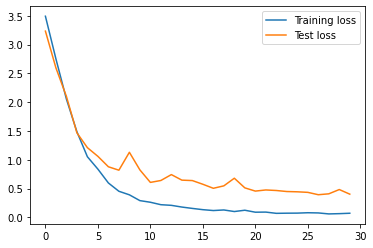

In [28]:
# train and validate
num_epochs = 30
train_loop(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

In [37]:
# get class to idx mapping
class_to_idx = dataset.class_to_idx
# idx to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [38]:
# save model
torch.save(model.state_dict(), 'gardenbirds.pth')

# save class to idx mapping
with open('idx_to_class.json', 'w') as f:
    json.dump(idx_to_class, f)

# save common to lating names
gardenbirds_sorted = {k: v for k, v in sorted(gardenbirds.items(), key=lambda item: item[1])}
# save
with open('gardenbirds_sorted.json', 'w') as f:
    json.dump(gardenbirds_sorted, f)

In [ ]:
# load model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))
model.load_state_dict(torch.load('gardenbirds.pth', map_location=torch.device('cpu')))
model.eval()

In [45]:
# predict class from image
def predict(inp):
    # inp to PIL
    inp = Image.open(inp)
    # transform pil image to tensor
    inp = data_transforms['val'](inp).unsqueeze(0)
    with torch.no_grad():
        prediction = torch.nn.functional.softmax(model(inp)[0], dim=0)
        #print(prediction)
        confidences = {list(gardenbirds_sorted.keys())[i]: float(prediction[i]) for i in range(26)}
    return confidences 

out = predict('parus_major.jpg')
# take top three predictions
top3 = sorted(out.items(), key=lambda x: x[1], reverse=True)[:3]
top3

[('great tit', 0.9126438498497009),
 ('magpie', 0.023727955296635628),
 ('great spotted woodpecker', 0.017165912315249443)]